In [50]:
import numpy as np
from pytisean import tiseanio
from datasets import *
from pendulum import *
from rk4 import rk4
from matplotlib import pyplot as plt
from curvature import *
from subprocess import call
import pandas as pd
import scipy as sp
from scipy import constants 

n=50000
timestep=0.01

params = {'legend.fontsize': 12,
          'legend.handlelength': 2}
plt.rcParams.update(params)

In [51]:
def plot_d2_with_slopes(d2,dims, filename, limits, start_dim=1):
    
    data_per_dim = int(d2.shape[0] / dims)
    plt.figure(figsize=(12,8), dpi=300)
    for dim in range(start_dim,dims+1):
        
        idx = (np.where(np.logical_and(d2[(dim-1)* (data_per_dim):(dim * data_per_dim),0] >= limits[0],
                            d2[(dim-1)* (data_per_dim):(dim * data_per_dim),0] < limits[1])))
        
        [p, COV] = np.polyfit(d2[(dim-1)* (data_per_dim):(dim * data_per_dim),0][idx], 
                 d2[(dim-1)* data_per_dim:(dim * data_per_dim),1][idx], deg=1, cov=True)
        
        plt.plot(d2[(dim-1)* (data_per_dim):(dim * data_per_dim),0], 
                 d2[(dim-1)* data_per_dim:(dim * data_per_dim),1], '.', 
                 #label=r'm=%d, d2=%.2f $\pm$ %.2f' % (dim, p[0], np.sqrt(COV[0][0])))
                 label=r'm=%d, d2=%.2f' % (dim, p[0]))
            
        x_coord = np.arange(limits[0],limits[1],0.1)
        y_coord = x_coord * p[0] + p[1]
        print(dim, p[0])
        
        plt.axvline(x=limits[0], color='black', markersize=.01)
        plt.axvline(x=limits[1], color='black', markersize=.01)
        #plt.plot(x_coord, y_coord, color='black')

    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel(r'log ($\epsilon$)', fontsize=20)
    plt.ylabel(r'log (C($\epsilon$))', fontsize=20)    
    plt.legend(prop={'size': 16})
    plt.savefig(filename)
    plt.show()

def plot_d2(d2,dims, filename, limits):
    
    data_per_dim = int(d2.shape[0] / dims)
    plt.figure(figsize=(12,8), dpi=300)
    for dim in range(1,dims+1):
        
        plt.plot(d2[(dim-1)* (data_per_dim):(dim * data_per_dim),0], 
                 d2[(dim-1)* data_per_dim:(dim * data_per_dim),1], '.', 
                 label=r'm=%d' % (dim))
       
    plt.xlabel(r'log ($\epsilon$)', fontsize=16)
    plt.ylabel(r'log (C($\epsilon$))', fontsize=16)    
    plt.legend(prop={'size': 16})
    plt.savefig(filename)
    plt.show()

    
def fit_slopes(d2, dims, limits):
    data_per_dim = int(d2.shape[0] / dims)
    print(limits)
    for dim in range(1,dims+1):
        
        idx = (np.where(np.logical_and(d2[(dim-1)* (data_per_dim):(dim * data_per_dim),0] >= limits[0],
                            d2[(dim-1)* (data_per_dim):(dim * data_per_dim),0] < limits[1])))
        
        [p, COV] = np.polyfit(d2[(dim-1)* (data_per_dim):(dim * data_per_dim),0][idx], 
                 d2[(dim-1)* data_per_dim:(dim * data_per_dim),1][idx], deg=1, cov=True)
        print(r'embedding dim={}, correlation dimension={}+/-{}'.format(dim, p[0], np.sqrt(COV[0][0])))
        
def moving_average(x, window = 4):
    
    s = pd.Series(x)
    s_ma = s.rolling(window).mean()

    return (np.array(s_ma)[window:])
    
    

# 2 Torus


In [69]:
def data_torus(noise_level, step_size, num_points):

    data = np.zeros((num_points,3))
    t = np.arange(num_points) * step_size
    
    print(t.shape, data.shape)
    
    R = 1
    r = 0.2
    pi = np.pi
    
    data[:,0] = (R + r*np.cos(2*pi*t))*np.sin(2*pi*constants.golden*t)
    data[:,1] = (R + r*np.cos(2*pi*t))*np.cos(2*pi*constants.golden*t)
    data[:,2] = r*np.sin(2*pi*t)
    
    print(data.shape, t.shape)
    data = data[10000:,:];
    t = t[10000:]
    max_val = (np.max((data[:,1])) - np.min((data[:,1]))) / 2
    series = data[:,1] + noise_level*max_val*(np.random.random((data.shape[0])) - .5)
    
    return [t, data, series]

step_size = 0.0005
num_points = 400000

t1, data1, x1 = data_torus(0.0, step_size, num_points)

(400000,) (400000, 3)
(400000, 3) (400000,)


In [70]:
ds_rate = 1

data = data1[::ds_rate,:]
x = x1[::ds_rate]
t = t1[::ds_rate]
print(data.shape)

(390000, 3)


446
Additional non-data files were created
3 2.0784508309492407


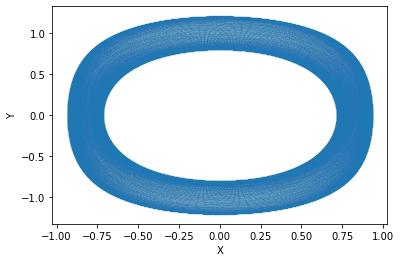

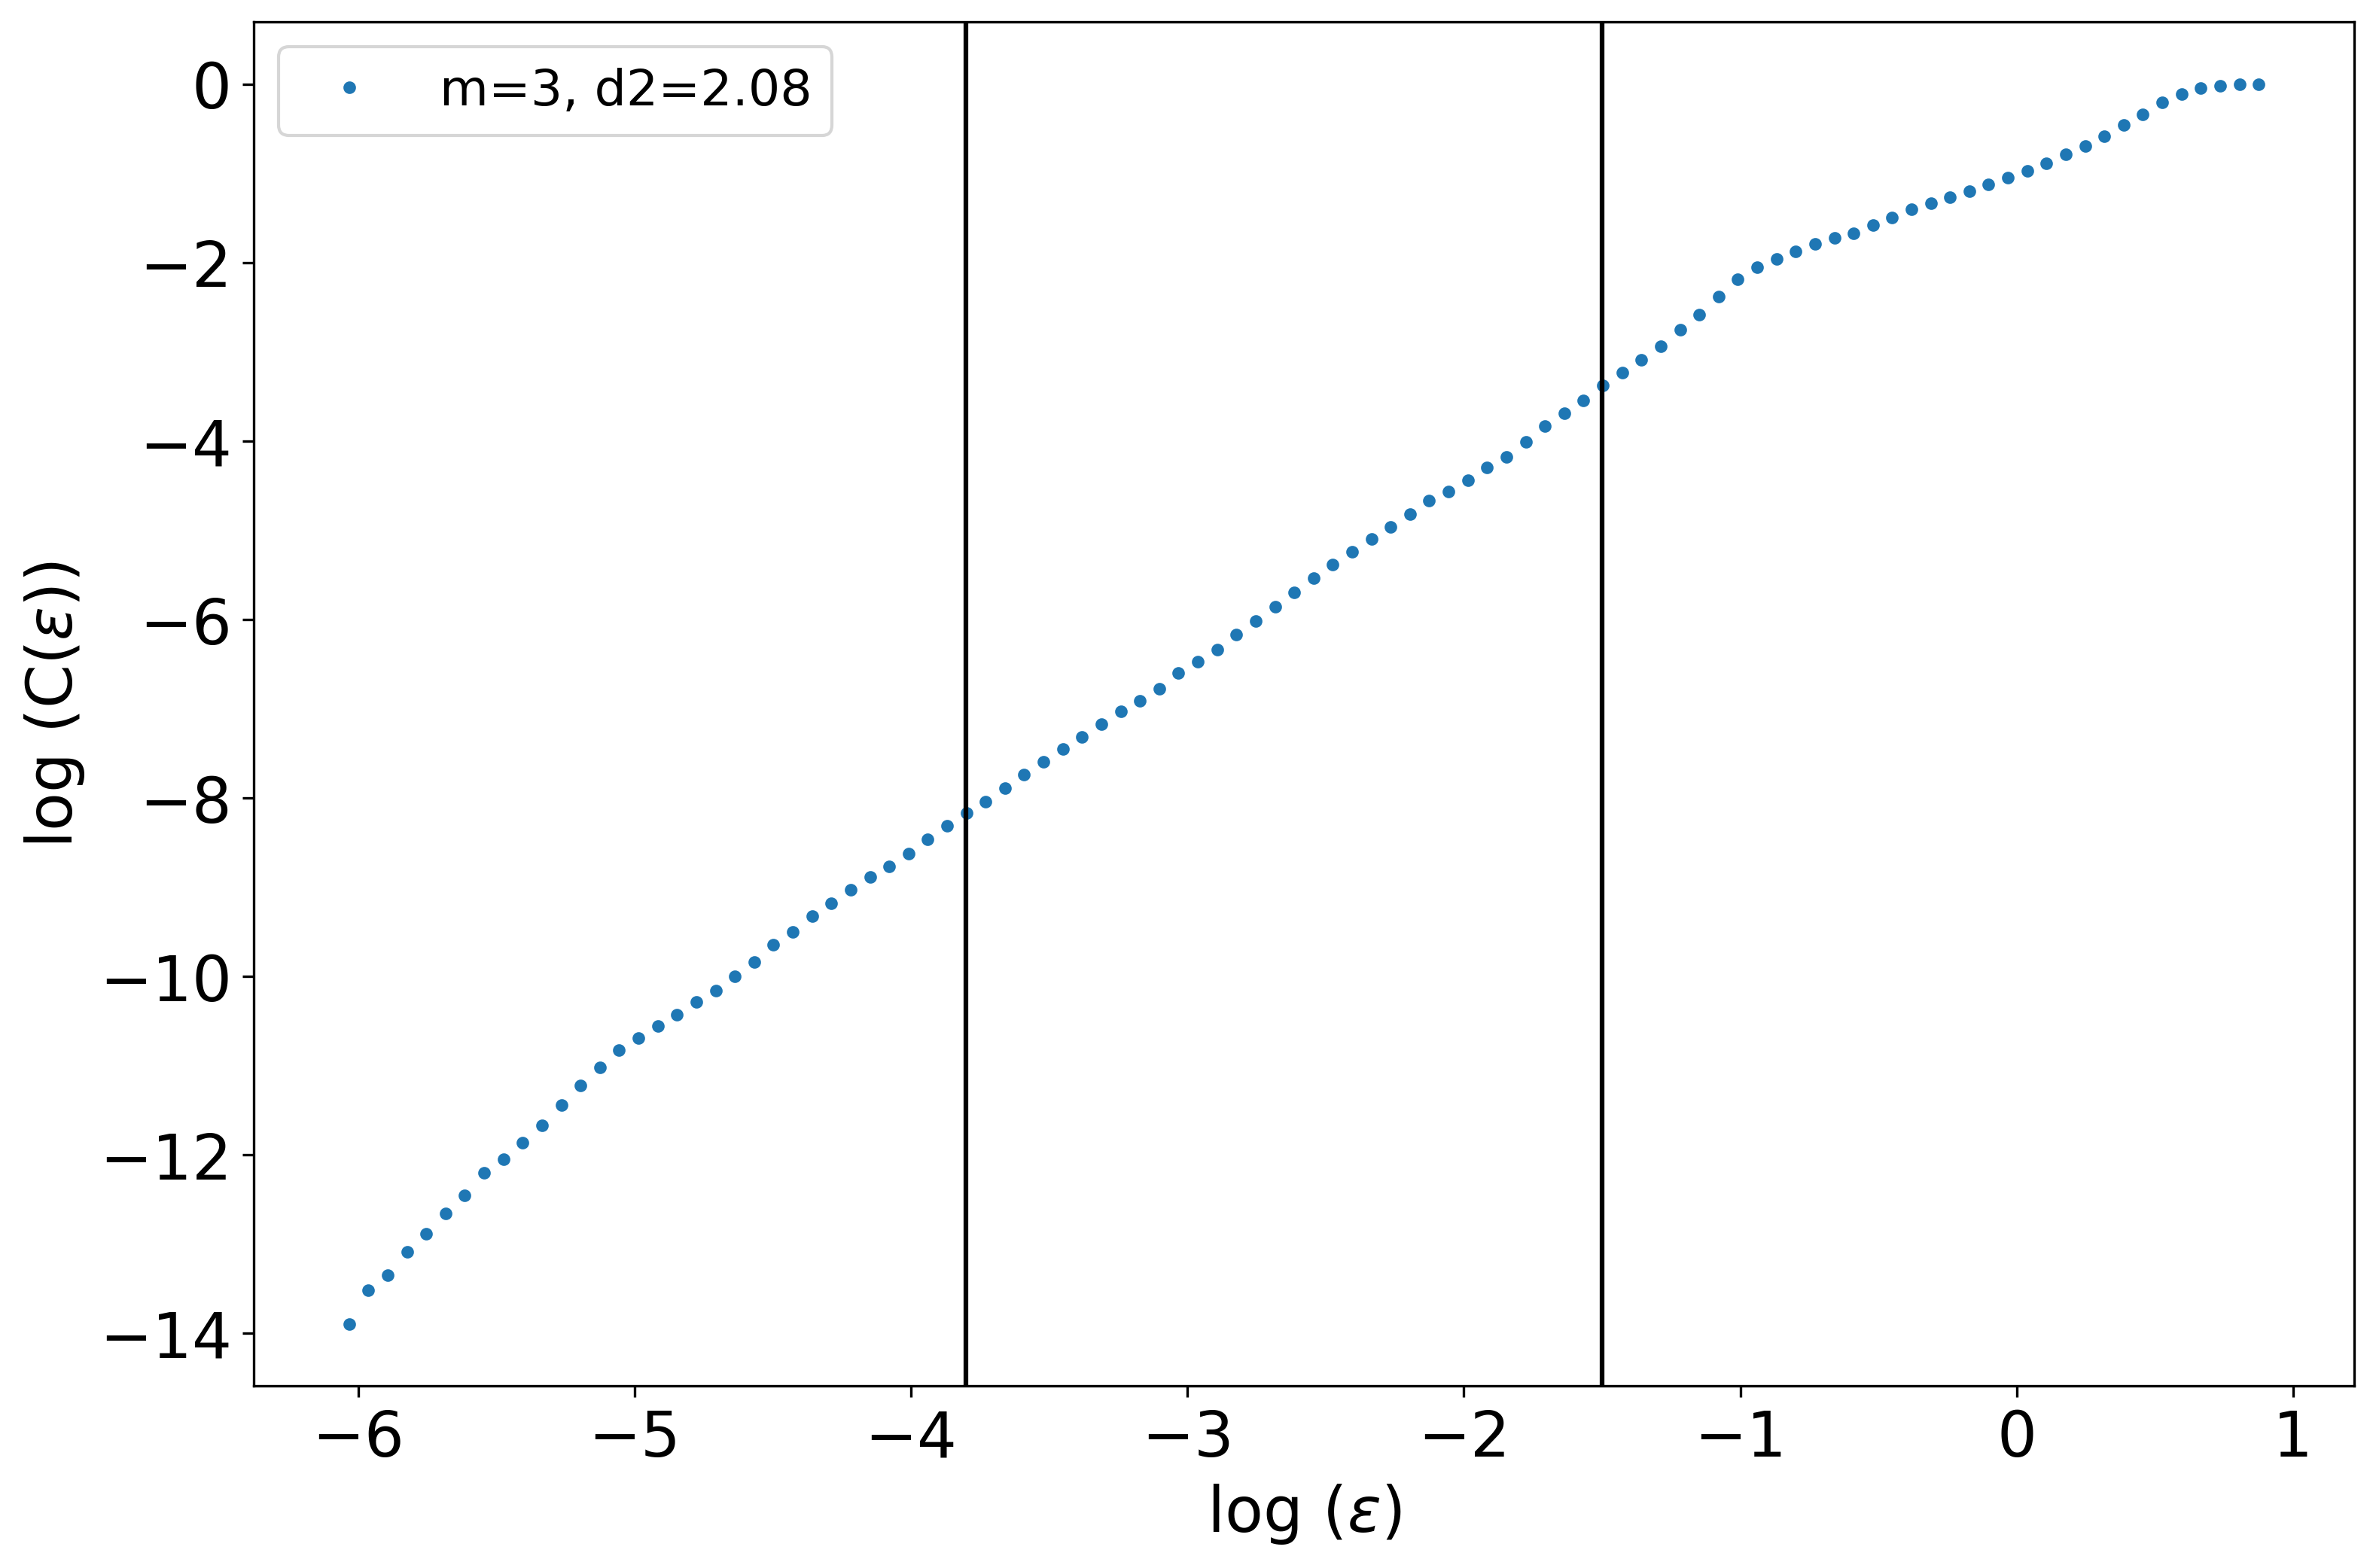

[-3.8, -1.5]
embedding dim=1, correlation dimension=0.9900640180887945+/-0.002301768928420257
embedding dim=2, correlation dimension=1.799633601084042+/-0.005461174149498398
embedding dim=3, correlation dimension=2.0784508309492407+/-0.00699529879246188


In [71]:
plt.figure()
plt.plot(np.sin(data[:,0]), data[:,1], '.', markersize=.1)
plt.xlabel(r'X')
plt.ylabel(r'Y')
plt.savefig('torus_state_space_ds_rate_{}.png'.format(ds_rate))

limits=[-3.8,-1.5]
dims = 3
theiler_window = int(2.718**limits[-1]/step_size/ds_rate)
print(theiler_window)
corr = tiseanio('d2','-M','3,1','-c','1,2,3', '-t', theiler_window, data=data, silent=True)
c2 = corr[0]['c2']
#log_c2 = np.concatenate((np.log(c2[:,0]).reshape(-1,1), np.log(c2[:,1]).reshape(-1,1)), axis=1)
log_c2 = np.log(c2)
plot_d2_with_slopes(log_c2, dims, 'd2_figures_paper/torus_full_ds_rate_{}_limits_{}_{}.png'.format(ds_rate, limits[0], limits[1]), limits, 
                    start_dim=3)
fit_slopes(log_c2, dims, limits)


In [72]:
x_ma = moving_average(x, window=20)
print(x)
print(x_ma)

[ 1.01250635  1.0092185   1.00590292 ... -0.95107969 -0.94735179
 -0.94359783]
[ 0.9761716   0.9725997   0.9690012  ... -0.98472096 -0.98124798
 -0.97774791]


In [64]:
tau_max = int(500 / ds_rate)
mutual, err = tiseanio('mutual', '-D', tau_max, data=x)
#embed, err = tiseanio('delay', '-m', 2, '-d', tau, data=lorenzTS, silent=True)

def get_menger_tau(data, tau_max):
    menger = [];
    dim = 2
    tau_avg = 1
    n_neighbors = 0
    menger_params = np.array([data.shape[0], 2, tau_max, tau_avg, n_neighbors])
    np.savetxt('menger_params.txt', menger_params)
    np.savetxt('menger_in.txt', data);
    np.savetxt('menger_params.txt', menger_params, fmt="%d")
    
    call(["./menger", "menger_in.txt", "menger_out.txt", "menger_params.txt"])
    menger_data = np.loadtxt("menger_out.txt");
    return menger_data[:,0], menger_data[:,1]

[menger_mean, menger_var] = get_menger_tau(x_ma, tau_max)


TISEAN 3.0.1 (C) R. Hegger, H. Kantz, T. Schreiber (1998-2007)

mutual: Estimates the time delayed mutual information
	of the data set

Using /tmp/pytisean_temp_2020-02-10-14-43-53_qkqi9f60/inFile as datafile, reading column 1
Use 490000 lines.
Opened /tmp/pytisean_temp_2020-02-10-14-43-53_qkqi9f60/outFile for writing



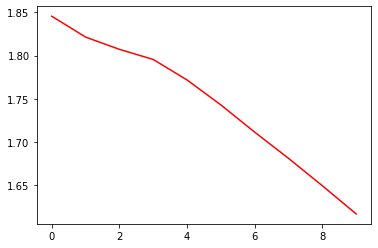

[[10.        1.845523]
 [11.        1.821361]
 [12.        1.80717 ]
 [13.        1.79541 ]
 [14.        1.771682]
 [15.        1.742771]
 [16.        1.71123 ]
 [17.        1.680871]
 [18.        1.649141]
 [19.        1.61649 ]]
[8.22147 7.54819 6.97815 6.48942 6.06585 5.69531 5.36849 5.07813 4.81851
 4.58501]


In [65]:
tau=20
plt.figure()
#plt.plot(menger_mean[:], 'b')

plt.plot(mutual[10:20,1], 'r')
#plt.plot(menger_mean[:,1], 'b')
plt.show()

print(mutual[10:20])
print(menger_mean[10:20])


No handles with labels found to put in legend.


(501, 2) (499,)


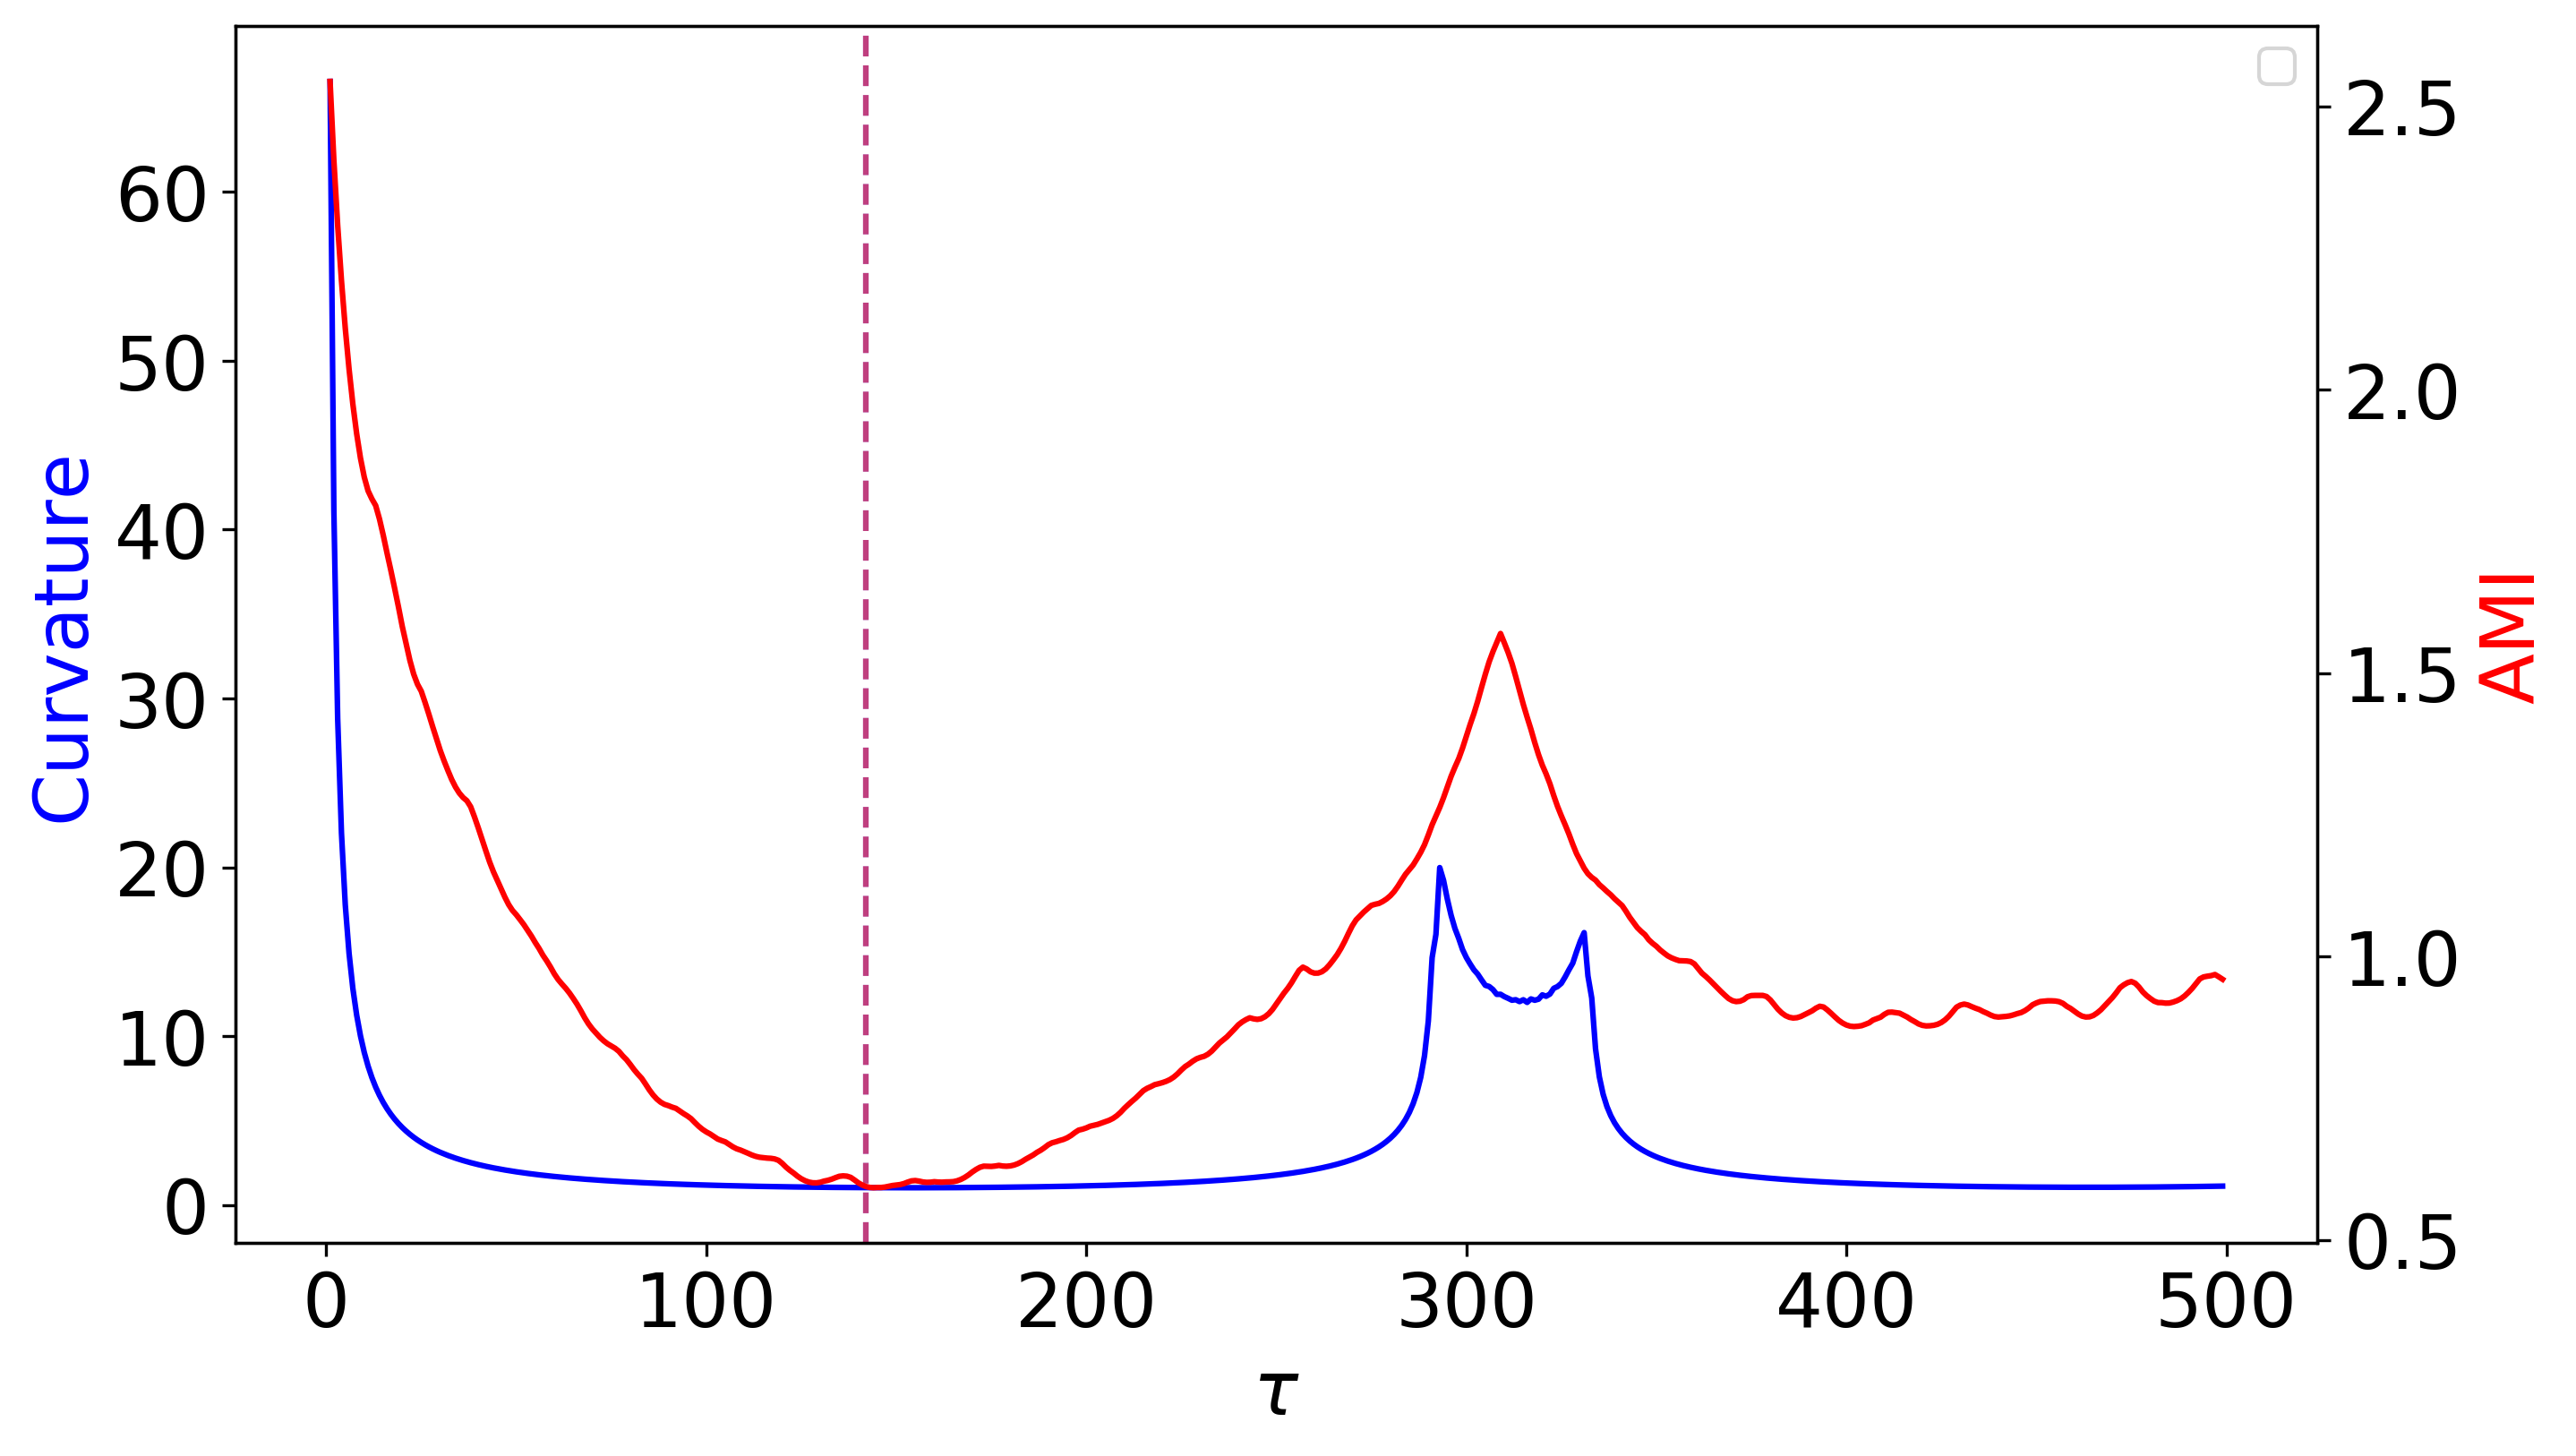

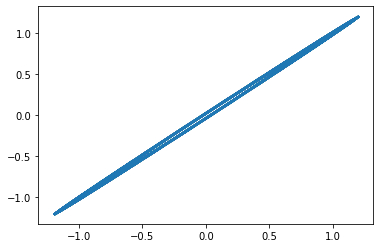

In [66]:
tau = 3
print(mutual.shape, menger_mean.shape)

xrange = np.arange(1, tau_max)
fig, ax1 = plt.subplots(figsize=(10,6), dpi=300)
ax1.plot(xrange, menger_mean[:], color='b')
ax1.set_xlabel(r'$\tau$', fontsize=20)
ax1.set_ylabel(r'Curvature', color = 'b', fontsize=20)
ax2 = ax1.twinx()
ax2.plot(xrange, mutual[1:-1,1], color = 'r')
ax2.set_ylabel(r'AMI', color = 'r', fontsize=20)
ax1.axvline(x = 142, color='b', linestyle='--', alpha=0.5)
ax2.axvline(x = 142, color='r', linestyle='--', alpha=0.5)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)
ax2.yaxis.set_tick_params(labelsize=20)
plt.legend()
plt.savefig('d2_figures_paper/torus_measures_vs_tau_ds_rate_{}.png'.format(ds_rate))

plt.figure()
plt.plot(x[:-tau], x[tau:],'.',markersize=0.1)
plt.show()

# Chaotic Pendulum tau = 20 (Curvature)

223
Additional non-data files were created
1 0.9712809748963191
2 1.7653565342379716
3 2.029883388756633
4 2.0506931039465326
5 2.0468442769202992


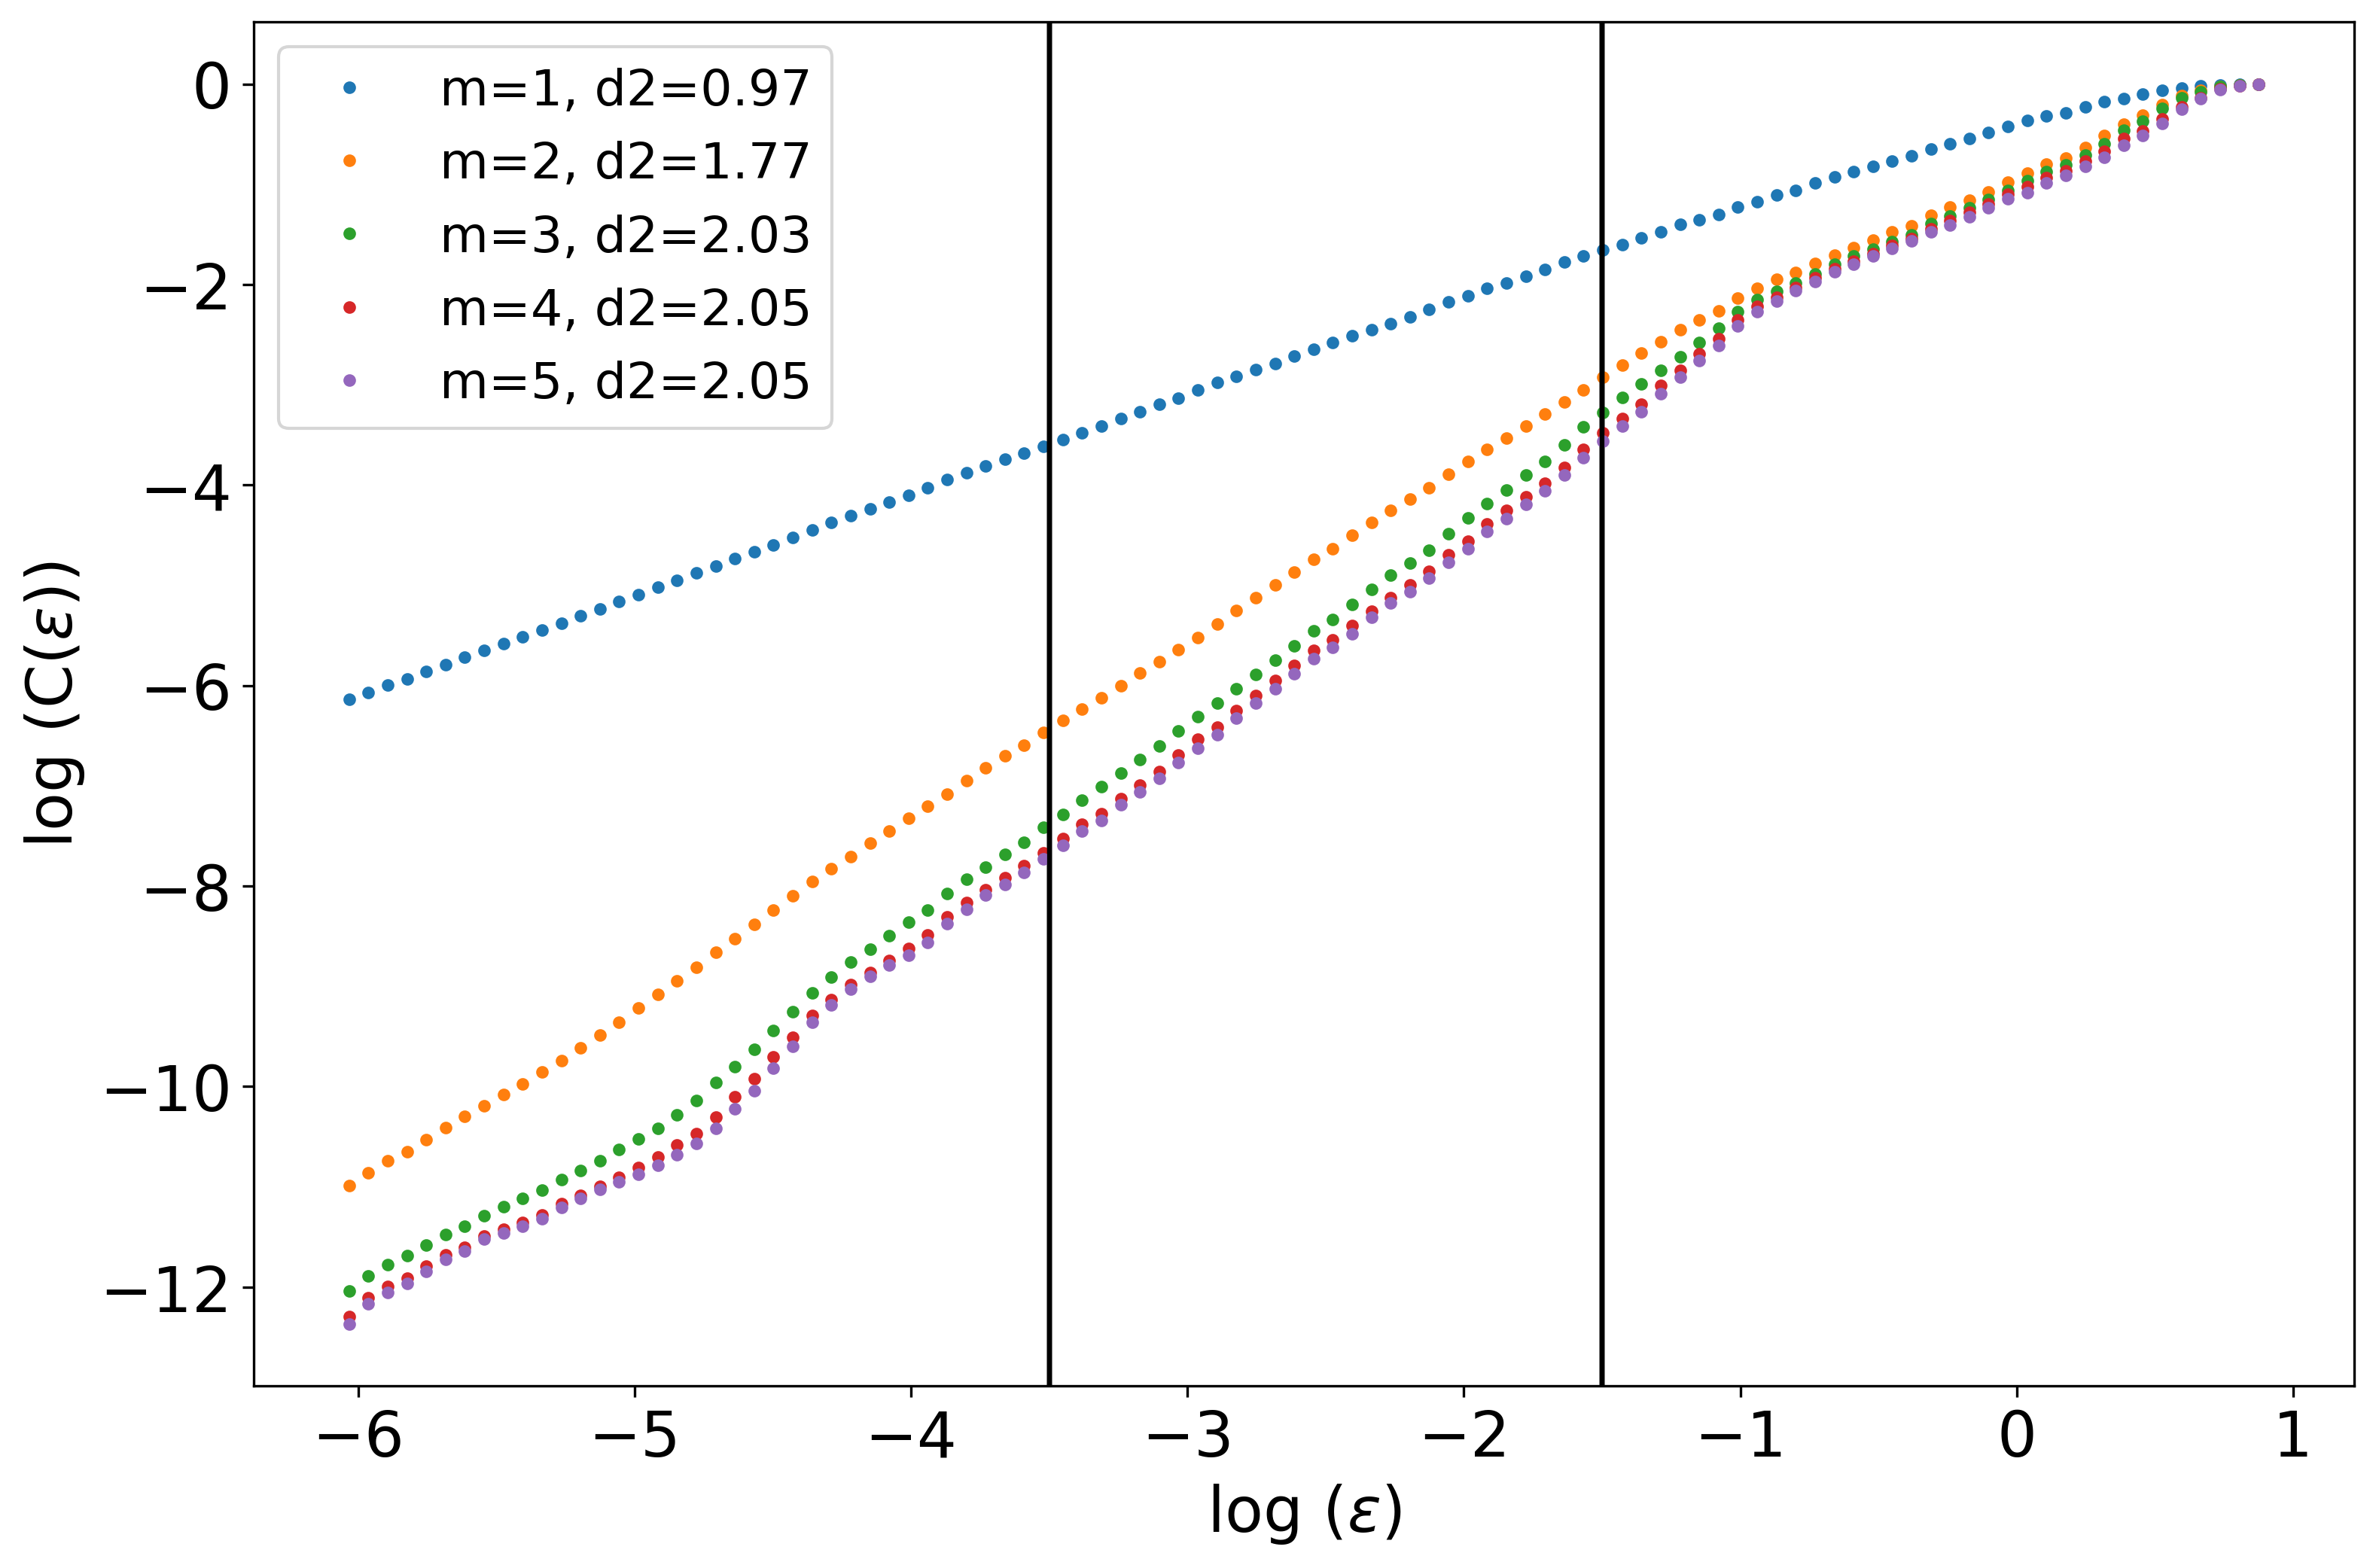

[-3.5, -1.5]
embedding dim=1, correlation dimension=0.9712809748963191+/-0.002772355339192313
embedding dim=2, correlation dimension=1.7653565342379716+/-0.004210535945260961
embedding dim=3, correlation dimension=2.029883388756633+/-0.005820318624595347
embedding dim=4, correlation dimension=2.0506931039465326+/-0.006727001391064594
embedding dim=5, correlation dimension=2.0468442769202992+/-0.005828268701789184


In [67]:
#[t, data] = get_lorenz(1000,100000)
#series = data[:,0]
tau = 142
#tau = 15
limits = [-3.5,-1.5]

#plt.figure()
#plt.plot(x[:-tau], x[tau:], '.', markersize=.1)
#plt.xlabel(r'$X_{t}$', fontsize=12)
#plt.ylabel(r'$X_{t+\tau}$', fontsize=12)
#plt.savefig('d2_figures_paper/torus_reconstruction_{}_ds_rate_{}.png'.format(tau, ds_rate, limits[0], limits[1]))

#series = data_lorenz(0,n=n,tmax=trans)
dims = 5
theiler_window = int(2.718**limits[-1]/step_size/ds_rate)
print(theiler_window)
corr = tiseanio('d2','-d',tau,'-M','1,{}'.format(dims), '-t', theiler_window, data=x, silent=True)

c2 = corr[0]['c2']
log_c2 = np.log(c2)
plot_d2_with_slopes(log_c2, dims, 'd2_figures_paper/torus_curvature_{}_ds_rate_{}_limits_{}_{}.png'.format(tau, ds_rate, limits[0], limits[1]), limits)
fit_slopes(log_c2, dims, limits)
#limits = [-1.2,1]
#plot_d2_with_slopes(log_c2, dims, 'torus_curvature_{}_ds_rate_{}.png'.format(tau, ds_rate), limits)
#plot_d2(log_c2, dims, '/tmp/chaotic_pendulum_curvature_100.png', limits)


# Chaotic Pendulum tau = 50 (Mutual)

223
Additional non-data files were created
1 0.9650055425770807
2 1.516497065418294
3 1.6470454979716322
4 1.7135139690998809
5 1.7431573665950544
6 1.7869695854596506
7 1.8340048304019712


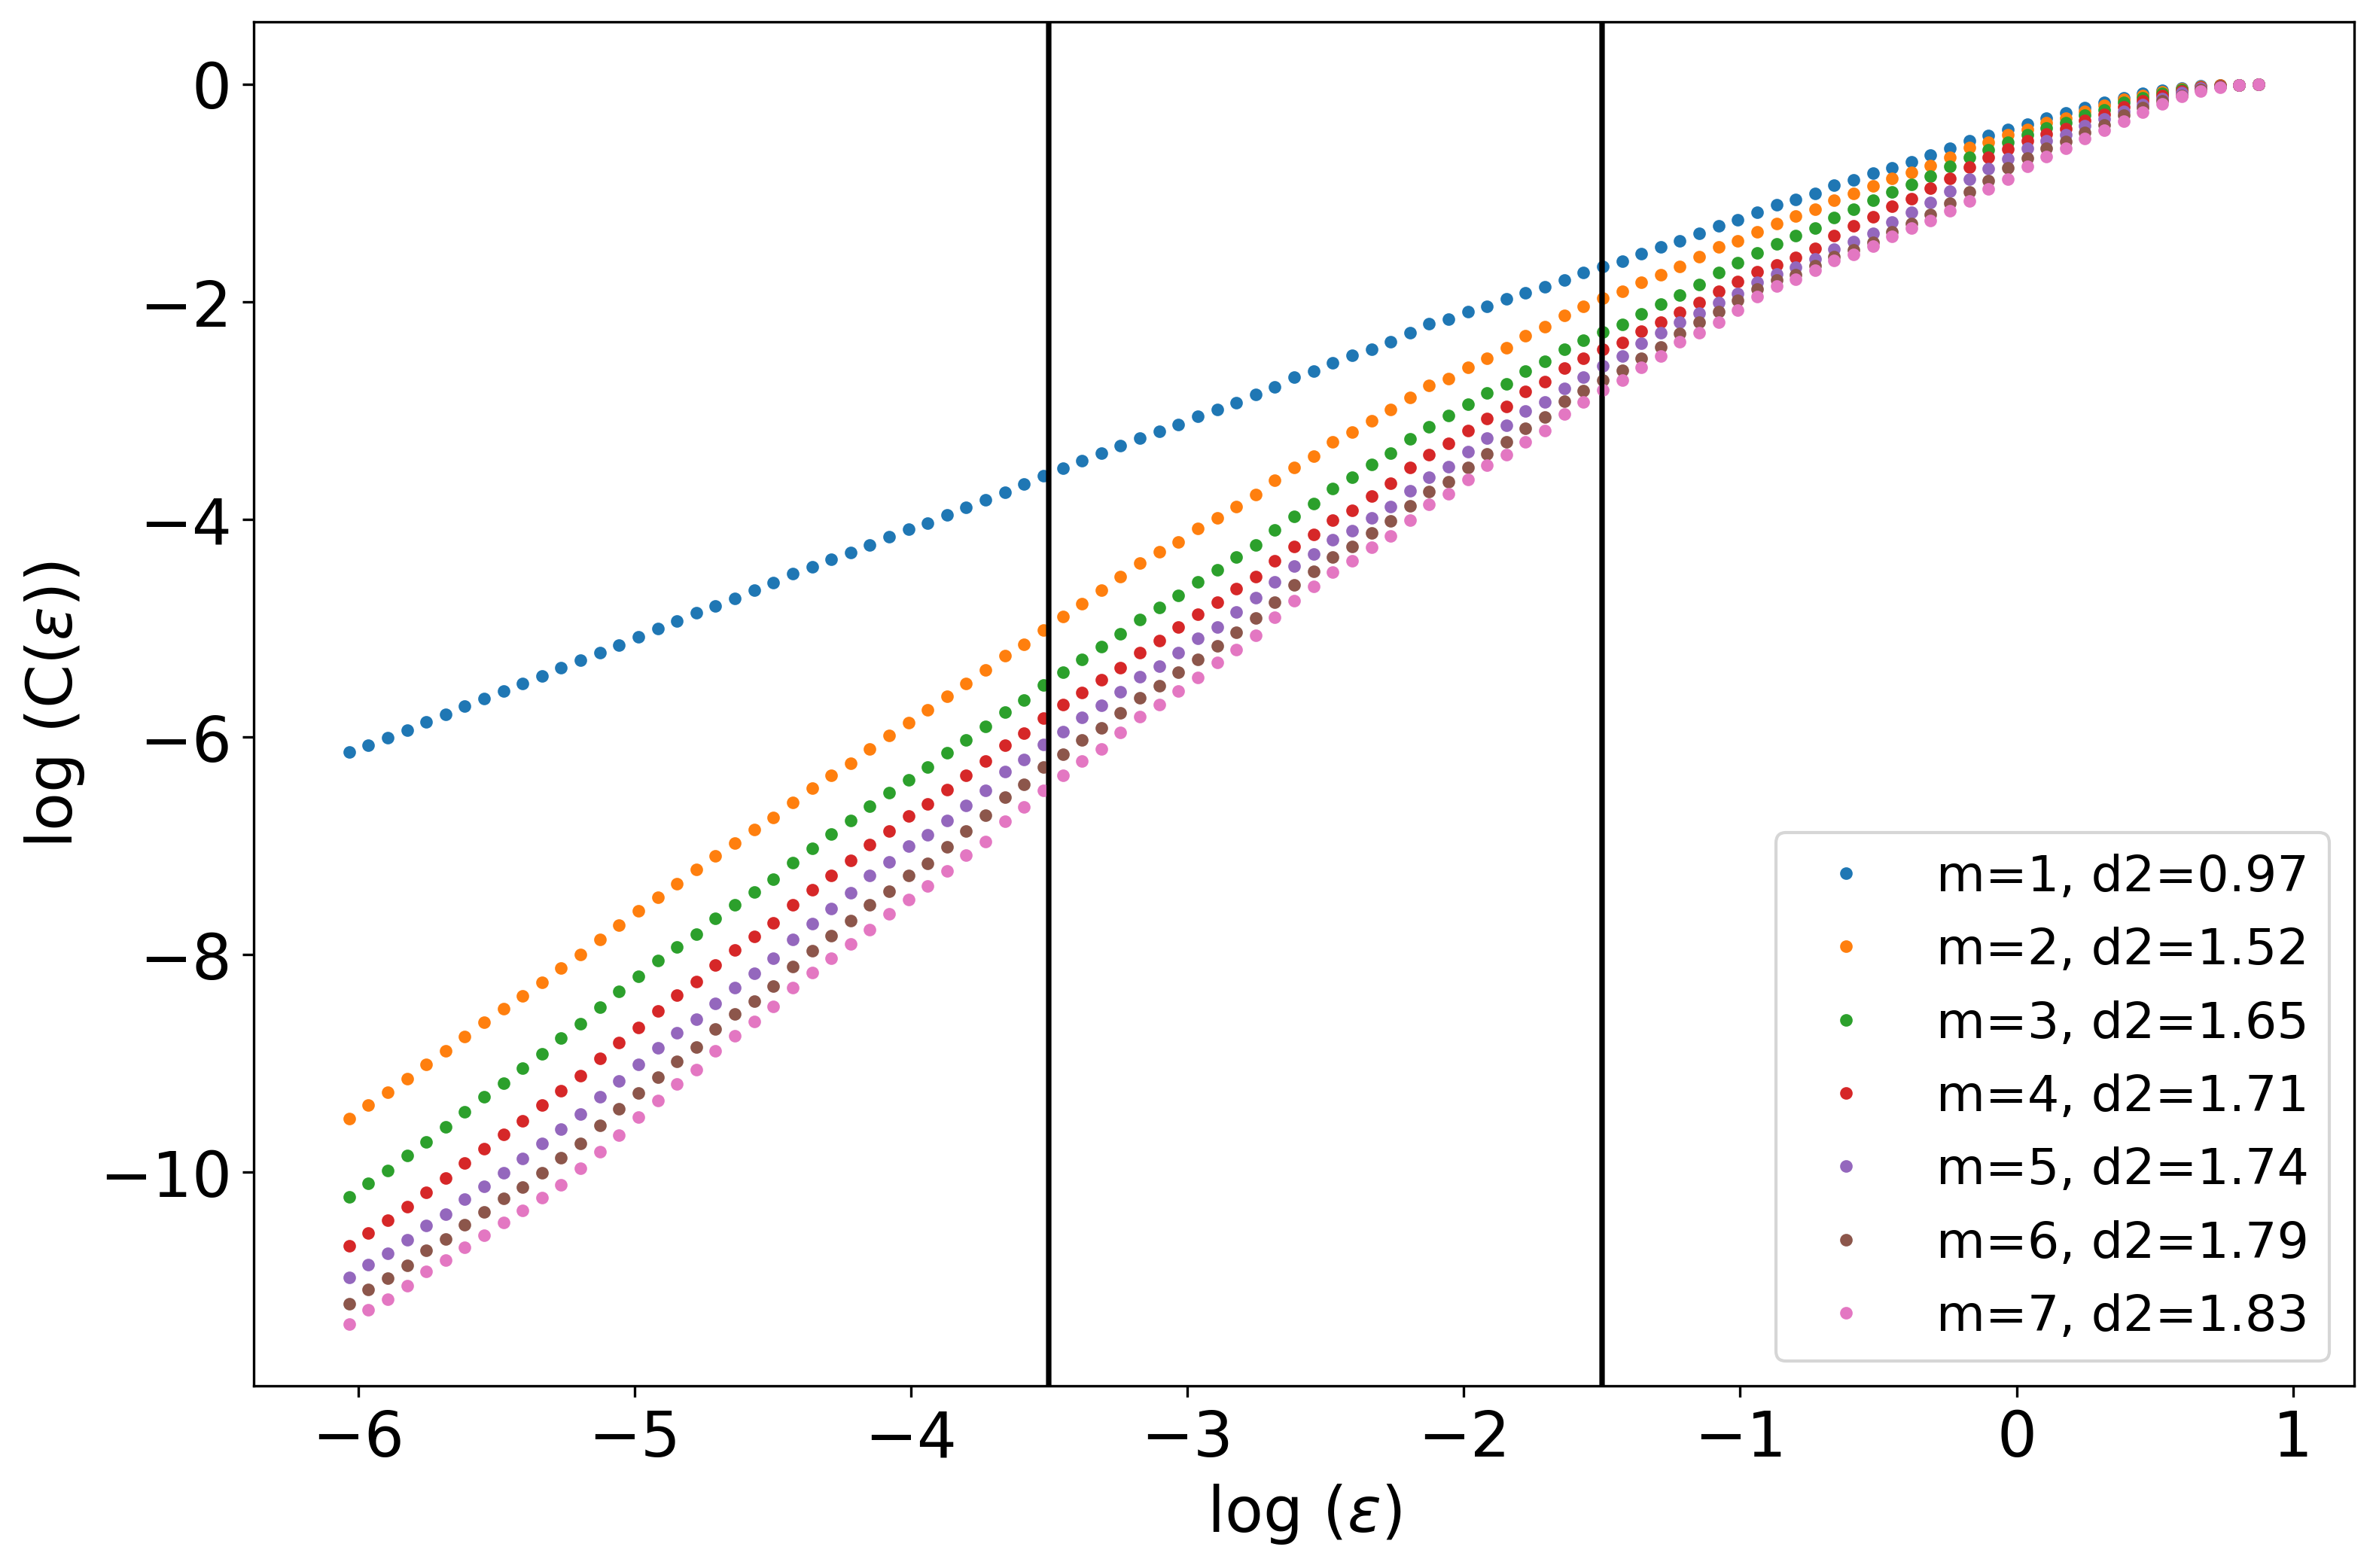

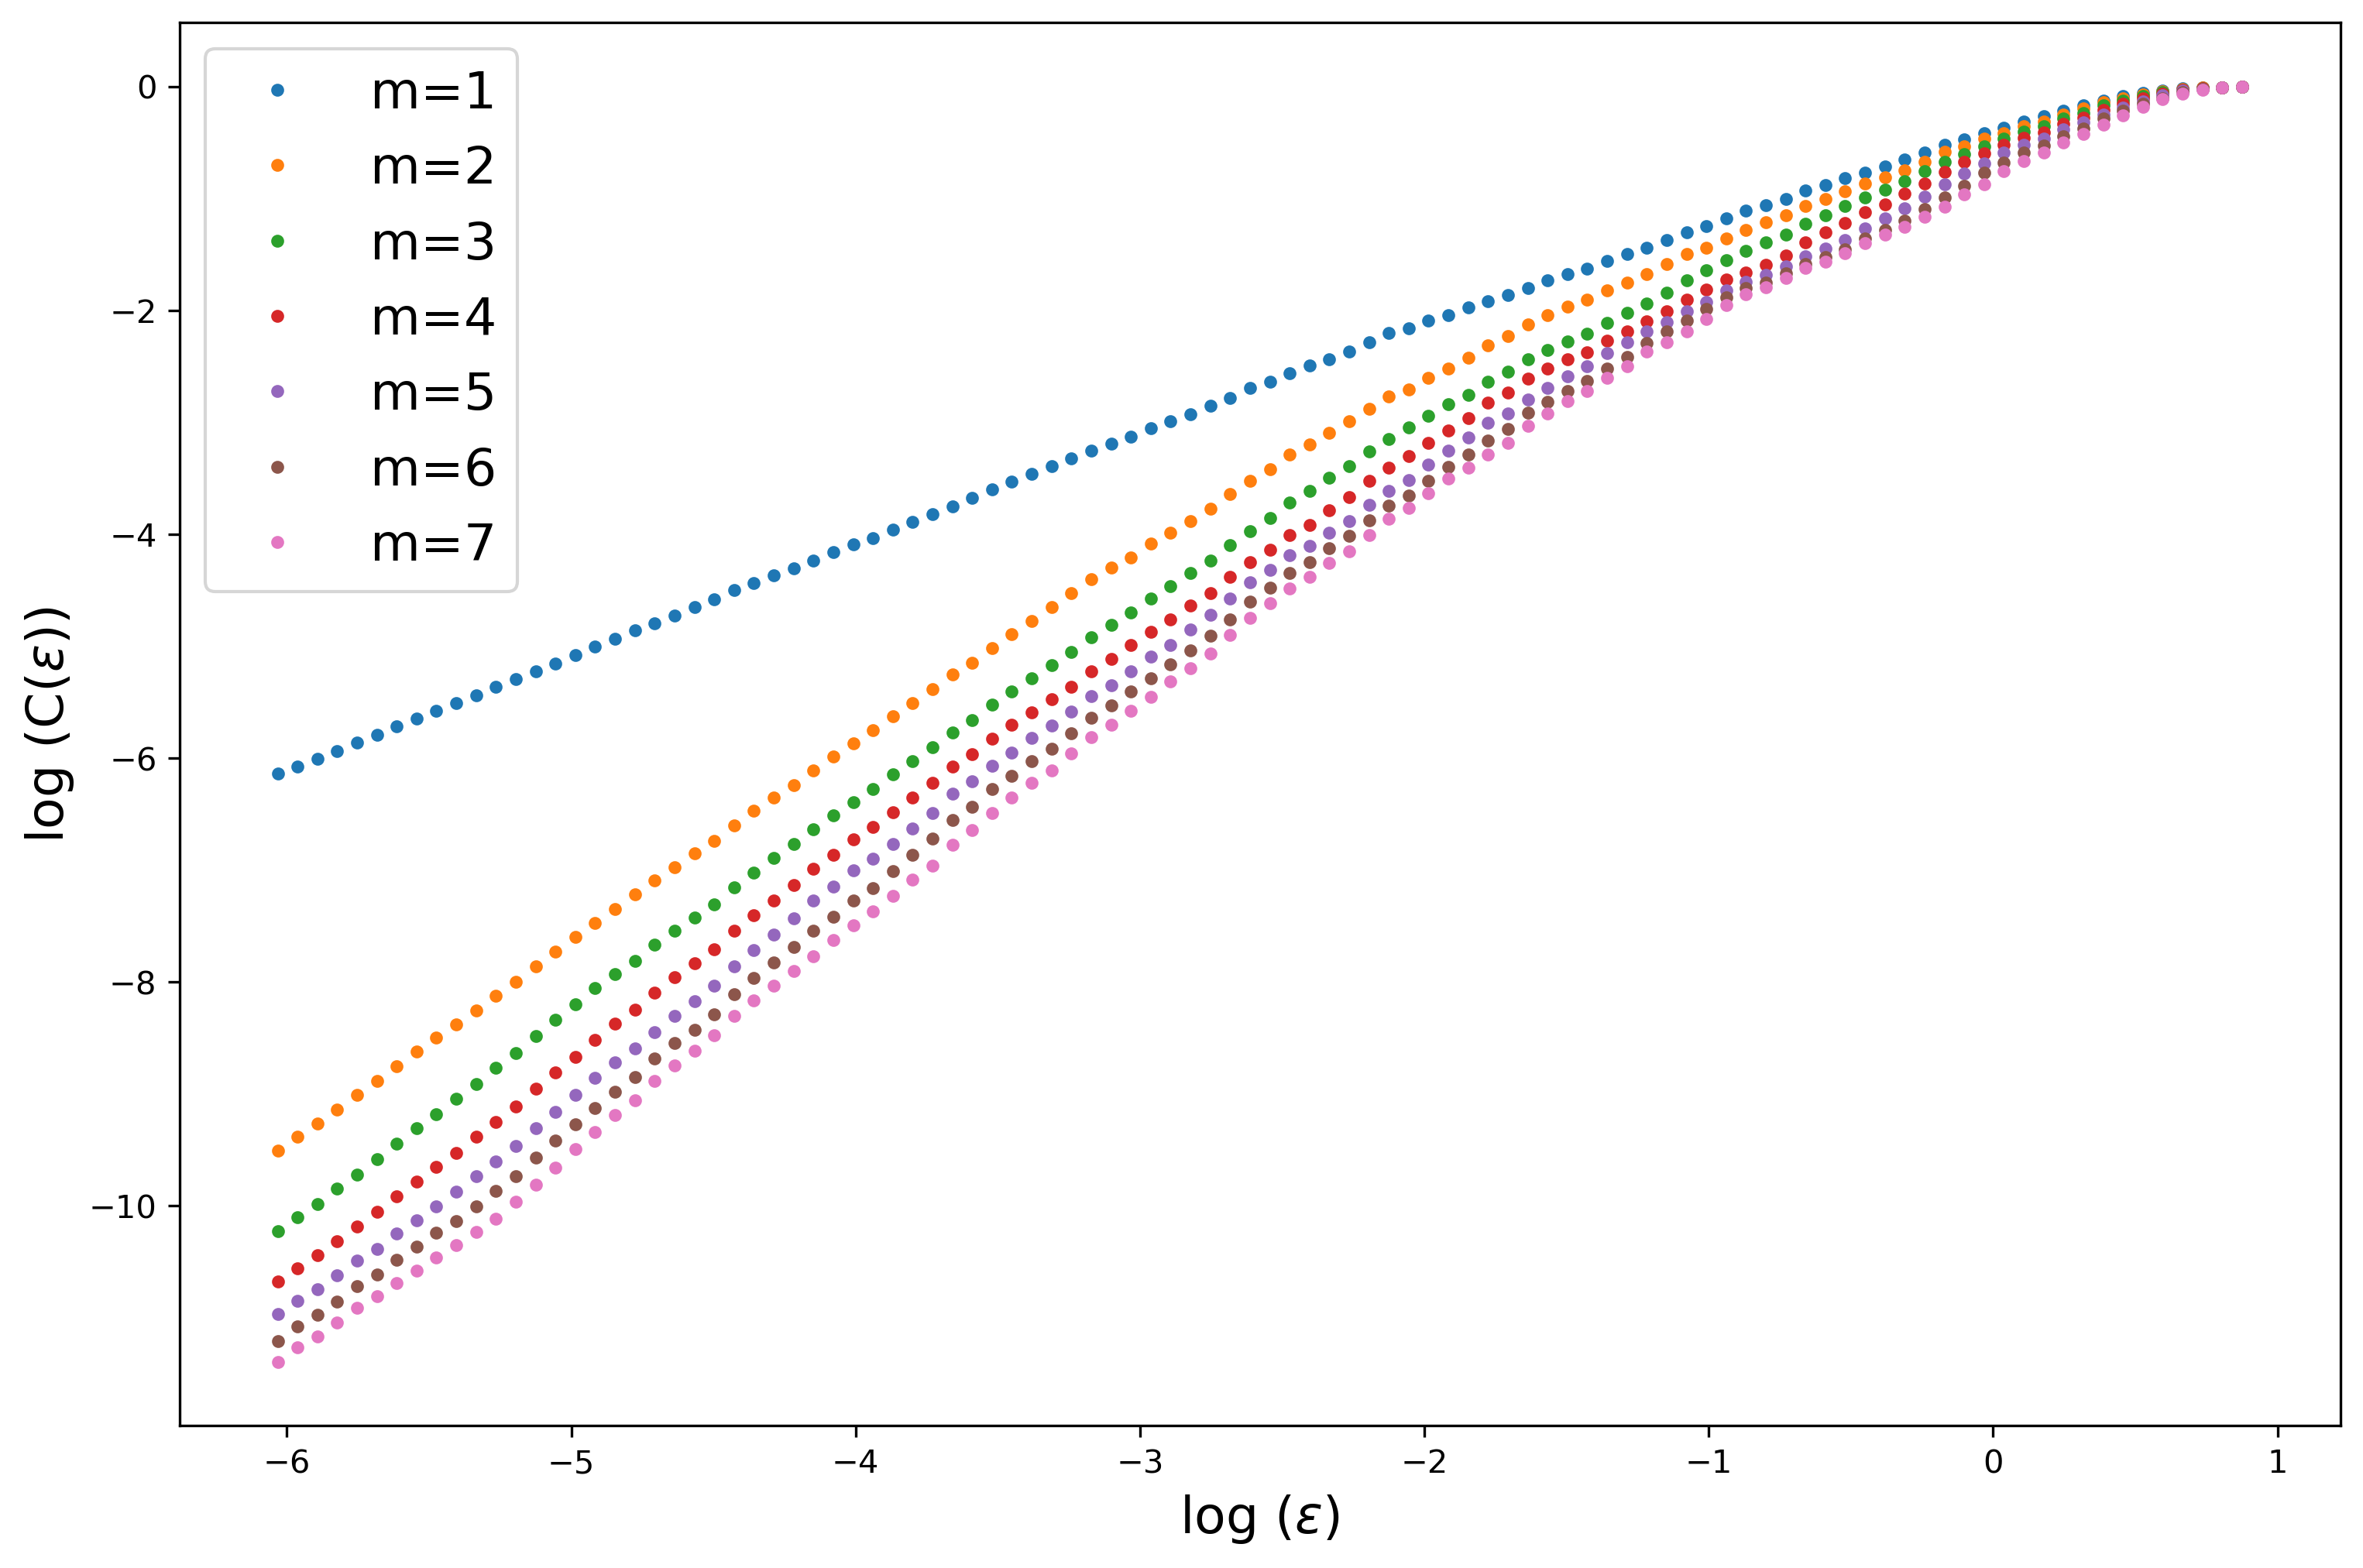

[-3.5, -1.5]
embedding dim=1, correlation dimension=0.9650055425770807+/-0.005458537771860705
embedding dim=2, correlation dimension=1.516497065418294+/-0.012709896516516854
embedding dim=3, correlation dimension=1.6470454979716322+/-0.01091097698714986
embedding dim=4, correlation dimension=1.7135139690998809+/-0.005268411355562551
embedding dim=5, correlation dimension=1.7431573665950544+/-0.007452889382888841
embedding dim=6, correlation dimension=1.7869695854596506+/-0.007997236975568646
embedding dim=7, correlation dimension=1.8340048304019712+/-0.009610356045797989


In [68]:
#[t, data] = get_lorenz(1000,100000)
#series = data[:,0]
tau = 15
limits = [-3.5,-1.5]

#series = data_lorenz(0,n=n,tmax=trans)
dims = 7
theiler_window = int(2.718**limits[-1]/step_size/ds_rate)
print(theiler_window)
corr = tiseanio('d2','-d',tau,'-M','1,{}'.format(dims), '-t', theiler_window, data=x, silent=True)

c2 = corr[0]['c2']
log_c2 = np.log(c2)
plot_d2_with_slopes(log_c2, dims, 'torus_curvature_{}_ds_rate_{}.png'.format(tau, ds_rate), limits)

#limits = [-1.2,1]
#plot_d2_with_slopes(log_c2, dims, 'chaotic_pendulum_curvature_{}_ds_rate_{}.png'.format(tau, ds_rate), limits)

plot_d2(log_c2, dims, '/tmp/chaotic_pendulum_curvature_100.png', limits)
fit_slopes(log_c2, dims, limits)

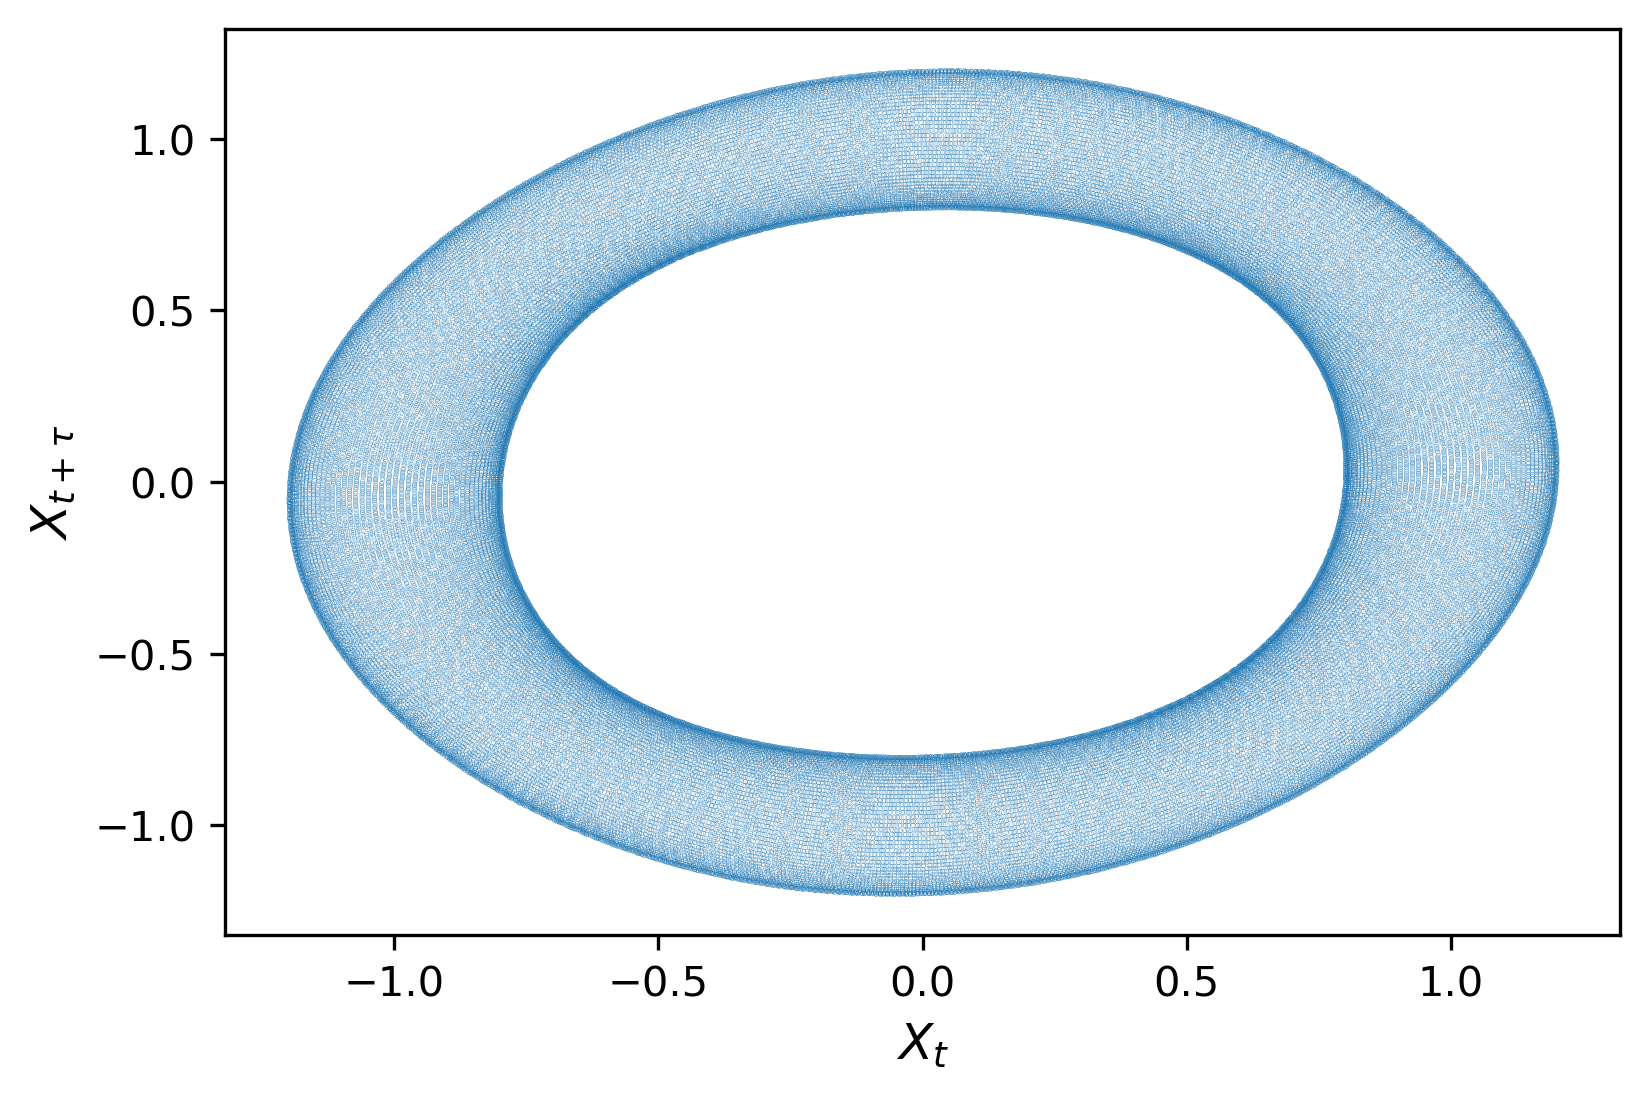

In [51]:
plt.figure(dpi=300)
plt.plot(x[:-tau], x[tau:], '.', markersize=.1)
plt.xlabel(r'$X_{t}$', fontsize=12)
plt.ylabel(r'$X_{t+\tau}$', fontsize=12)
plt.savefig('d2_figures_paper/torus_reconstruction_{}_ds_rate_{}.png'.format(tau, ds_rate))

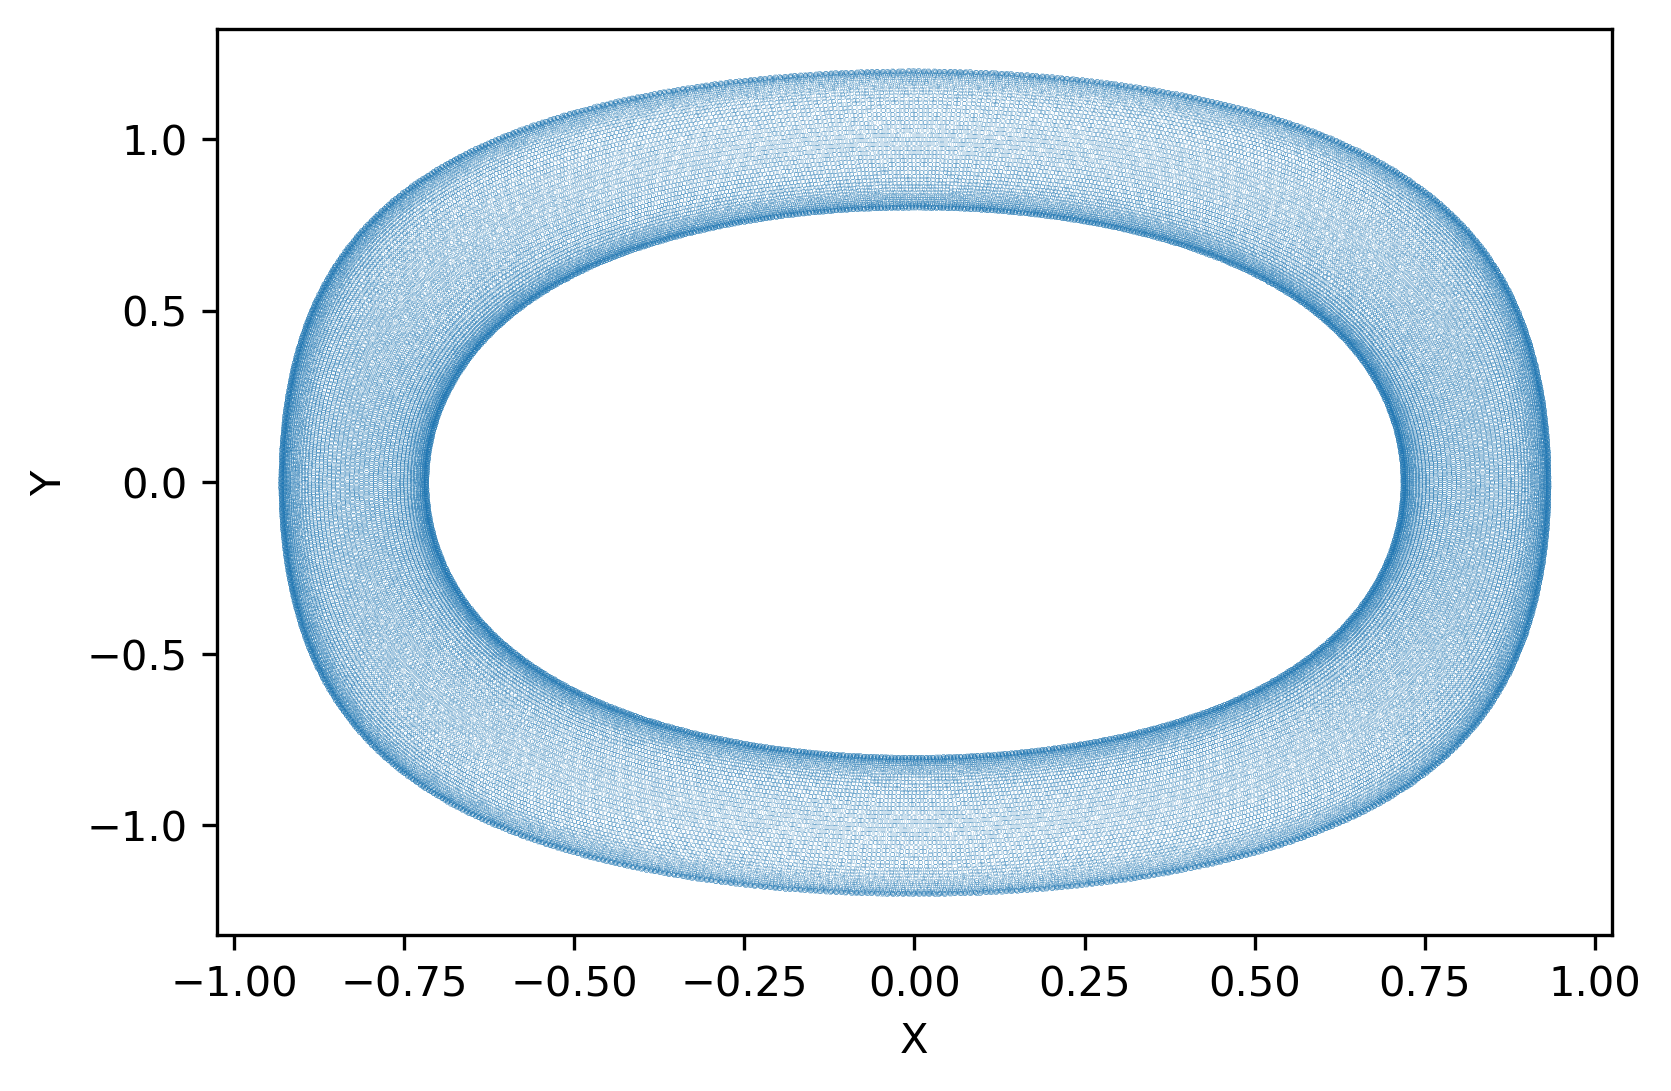

In [53]:
plt.figure(dpi=300)
plt.plot(np.sin(data[:,0]), data[:,1], '.', markersize=.1)
plt.xlabel(r'X')
plt.ylabel(r'Y')
plt.savefig('d2_figures_paper/torus_state_space_ds_rate_{}.png'.format(ds_rate))
